In [163]:
from tenzometer_calibration import readCalibration
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import linregress
import os
from datetime import datetime

In [164]:
calib = readCalibration("calibration/Tenzo2-08-05-2023-19-24-13.csv")
Vlimit = 0.00004
ramps = calib[calib["Status"].isin(["up","down"])]
ramps = ramps.loc[ramps["V"] > Vlimit]

rampsUp = calib[calib["Status"] == "up"]
rampsUp = rampsUp.loc[rampsUp["V"] > Vlimit]

rampsDown = calib[calib["Status"] == "down"]
rampsDown = rampsDown.loc[rampsDown["V"] > Vlimit]
len(rampsDown)

9

In [165]:


# def doFit():

slope, intercept, r_value, p_value, std_err  = linregress(ramps["F"],ramps["V"])
F_edges = [0,ramps["F"].max()+0.2]
calibLine = np.array([slope*F_edges[0] + intercept, slope*F_edges[1] + intercept])
print(len(ramps["F"]))
err = np.sqrt(np.sum(np.abs(slope*ramps["F"] + intercept - ramps["V"])**2)/(len(ramps["F"])-1))
calibBorders = np.array([[slope*F_edges[0] + intercept - err, slope*F_edges[1] + intercept - err],
                [slope*F_edges[0] + intercept + err, slope*F_edges[1] + intercept + err]
                ])


19


1.7424653099097855e-06

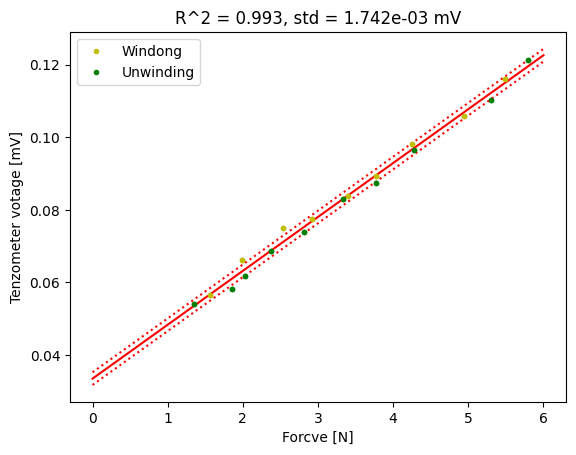

In [166]:


plt.plot(rampsDown["F"],rampsDown["V"]*10**3,".y")
plt.plot(rampsUp["F"],rampsUp["V"]*10**3,".g")
plt.legend(["Windong","Unwinding"])
plt.plot(F_edges, calibBorders[0]*10**3, ":r")
plt.plot(F_edges, calibBorders[1]*10**3, ":r")
plt.plot(F_edges, calibLine*10**3, "-r")
plt.plot(rampsDown["F"],rampsDown["V"]*10**3,".y")
plt.plot(rampsUp["F"],rampsUp["V"]*10**3,".g")

plt.xlabel("Forcve [N]")

plt.ylabel("Tenzometer votage [mV]")
plt.title("R^2 = %1.3f, std = %1.3e mV" %(r_value**2, err*10**3))

err

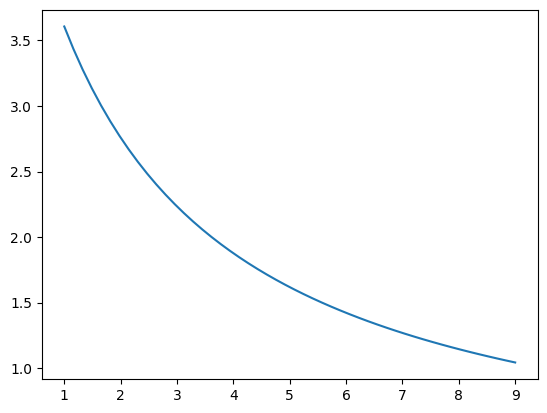

In [167]:
F = np.linspace(1,9)
rel_err = err/(slope*F + intercept)
plt.plot(F,rel_err*100)


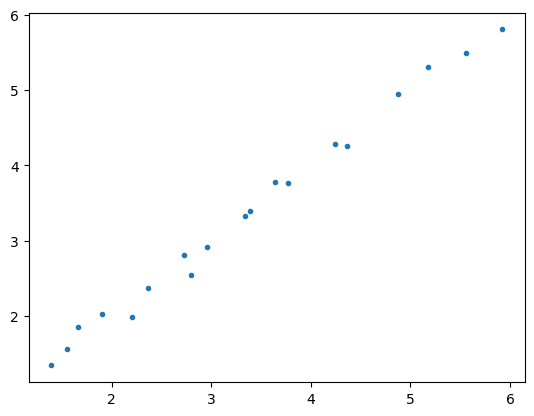

In [168]:
p = [- intercept/slope, 1/slope]
F = ramps["V"]*p[1] + p[0]

plt.plot(F, ramps["F"], ".")

0.1173458040933894

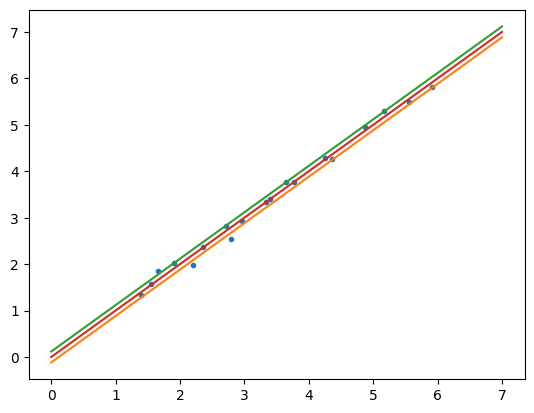

In [169]:
err = np.sqrt(np.sum(np.abs(F - ramps["F"])**2)/(len(F)-1))

errLine = [[ -err, 7 - err],
                [ err, 7 + err]
                ]

plt.plot(F, ramps["F"], ".")
plt.plot([0,7],errLine[0])
plt.plot([0,7],errLine[1])
plt.plot([0,7], [0,7])
err


In [170]:
drift = calib[calib["Status"] == "drift"]
print(drift)


             F         V         T1   T2   x Status  F_set
0     0.680160  0.000037   0.305069  0.0   0  drift    1.0
1     2.169363 -0.000005   2.782318  0.0  29  drift    1.0
2     2.256543  0.000069   3.383216  0.0  30  drift    1.0
3     2.272810  0.000065   3.708048  0.0  30  drift    1.0
4     2.233523  0.000064   4.008637  0.0  30  drift    1.0
...        ...       ...        ...  ...  ..    ...    ...
1455  1.061070  0.000039  16.669230  0.0  36  drift    1.0
1456  1.062493  0.000042  16.969446  0.0  36  drift    1.0
1457  1.063942  0.000040  17.269889  0.0  36  drift    1.0
1458  1.065294  0.000051  17.595123  0.0  36  drift    1.0
1459  1.066639  0.000053  17.895483  0.0  36  drift    1.0

[1440 rows x 7 columns]


In [176]:
F_set = drift["F_set"].unique()
driftUp = []
driftDown = []
I = calib.loc[calib["Status"] == "up"].index
i0 = 0
for i1 in I:
    driftUp.append(calib.iloc[i0:i1])
    i0 = i1+1

I = calib.loc[calib["Status"] == "down"].index
for i1 in I:
    driftDown.append(calib.iloc[i0:i1])
    i0 = i1+1


# F_set = [3, 5]
# for F in F_set:
#     I = drift.loc[drift["F_set"] == F].index
#     i0 = I[0]
#     ip = i0
#     for i in I:
#         if i > ip+1:
#             driftUp.append(drift.iloc[i0:ip])
#             print(i0,ip)
#             break
#         ip = i

    


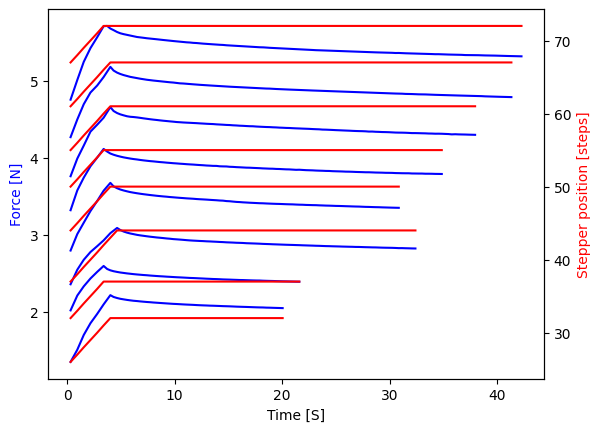

In [185]:
f = plt.figure()
ax0 = f.add_subplot(111)
ax0.set_xlabel("Time [S]")
ax0.set_ylabel("Force [N]", color = "b")
ax1 = ax0.twinx()
ax1.set_xlabel("Time [S]")
ax1.set_ylabel("Stepper position [steps]",color= "r")


for F in driftUp[2:-1]:
    ax0.plot(F["T1"], F["F"],"b")
    ax1.plot(F["T1"], F["x"],"r")



2.157045125961304


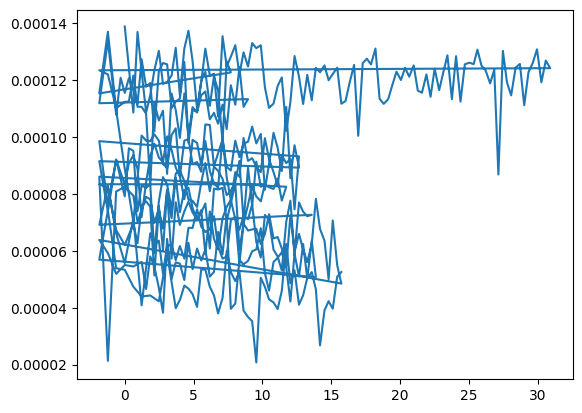

In [173]:
Fsettling = np.array(dynamic["V"])
Tsettling = np.array(dynamic["T1"])

i_start = int(np.argmax(Fsettling))
print(Tsettling[i_start])



Fsettling = np.array(Fsettling[i_start:])
Tsettling = np.array(Tsettling[i_start:]) - Tsettling[i_start]
plt.plot(Tsettling, Fsettling)

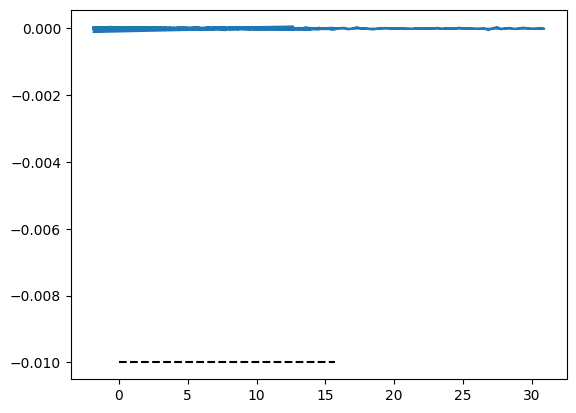

In [174]:
dFsettling = np.gradient(Fsettling, Tsettling)
plt.plot(Tsettling, dFsettling)
plt.plot([0,Tsettling[-1]], [-0.01, -0.01], "--k")